In [78]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import randint, uniform
import joblib

In [79]:
# data import


file_train = "/Users/bofanchen/Desktop/data_mining/[3] full dataset preparation and baseline model evaluation/train_data.csv"
file_val = "/Users/bofanchen/Desktop/data_mining/[3] full dataset preparation and baseline model evaluation/val_data.csv"

train = pd.read_csv(file_train)
val = pd.read_csv(file_val)

X_train, y_train = train.drop("is_canceled", axis=1), train["is_canceled"]
X_val, y_val = val.drop("is_canceled", axis=1), val["is_canceled"]

In [80]:
print("Training set class distribution:")
print(y_train.value_counts())
print("Number of columns in X_train:", X_train.shape[1])

Training set class distribution:
is_canceled
0.0    52568
1.0    30837
Name: count, dtype: int64
Number of columns in X_train: 131


In [81]:
# Define a basic KNN classifier with default parameters
baseline_knn = KNeighborsClassifier(
    n_neighbors=5,           # Default value
    weights='uniform',       # Default value
    algorithm='auto',        # Default value
    leaf_size=30,            # Default value
    p=2,                     # Euclidean distance
    metric='euclidean'       # Default value
)

# Fit the model on the training data
baseline_knn.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = baseline_knn.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print baseline model performance
print("Baseline KNN Model (k=5) Performance:")
print(f"Validation Accuracy: {accuracy:.5f}")
print(f"Validation Precision: {precision:.5f}")
print(f"Validation Recall: {recall:.5f}")
print(f"Validation F1 Score: {f1:.5f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Baseline KNN Model (k=5) Performance:
Validation Accuracy: 0.80667
Validation Precision: 0.76401
Validation Recall: 0.69973
Validation F1 Score: 0.73046

Confusion Matrix:
[[9754 1449]
 [2013 4691]]


In [82]:
def create_balanced_subset(X, y, target_size):
    """
    Create a balanced subset of data with equal class distribution and specified size.
    
    Parameters:
        X: Features dataframe or array
        y: Target labels (binary: 0 or 1)
        target_size: Desired size of the final subset
    
    Returns:
        X_subset, y_subset: Balanced data subset with the specified size
    """
    # Ensure target_size is even for equal class distribution
    if target_size % 2 != 0:
        target_size -= 1
        print(f"Adjusted target size to {target_size} to ensure equal class distribution")
    
    # Calculate samples needed per class
    samples_per_class = target_size // 2
    
    # Get indices for each class
    positive_indices = np.where(y == 1)[0]
    negative_indices = np.where(y == 0)[0]
    
    # Check if we have enough samples in each class
    if len(positive_indices) < samples_per_class or len(negative_indices) < samples_per_class:
        max_possible_size = 2 * min(len(positive_indices), len(negative_indices))
        if max_possible_size == 0:
            raise ValueError("One or both classes have no samples")
        print(f"Warning: Not enough samples to create subset of size {target_size}")
        print(f"Maximum possible balanced subset size: {max_possible_size}")
        samples_per_class = min(len(positive_indices), len(negative_indices))
        target_size = 2 * samples_per_class
    
    # Randomly select equal numbers from each class
    np.random.seed(42)  # For reproducibility
    balanced_pos_indices = np.random.choice(positive_indices, samples_per_class, replace=False)
    balanced_neg_indices = np.random.choice(negative_indices, samples_per_class, replace=False)
    
    # Combine the indices
    balanced_indices = np.concatenate([balanced_pos_indices, balanced_neg_indices])
    
    # Create balanced subset
    X_subset = X.iloc[balanced_indices] if isinstance(X, pd.DataFrame) else X[balanced_indices]
    y_subset = y.iloc[balanced_indices] if isinstance(y, pd.Series) else y[balanced_indices]
    
    return X_subset, y_subset

# create a balanced subset with given number

In [83]:
# Store the original data
X_train_original = X_train.copy()
y_train_original = y_train.copy()

# Create a balanced subset with specified size (e.g., 20,000 samples)
subset_size = 50000  # You can change this to any desired size
X_train, y_train = create_balanced_subset(X_train_original, y_train_original, subset_size)

# Verify the result
unique, counts = np.unique(y_train, return_counts=True)
balance_dict = dict(zip(unique, counts))
print(f"Class distribution in balanced X_train: {balance_dict}")
print(f"Percentage of positive class: {balance_dict[1] / sum(counts) * 100:.2f}%")
print(f"Original dataset size: {len(y_train_original)}")
print(f"New balanced X_train size: {len(y_train)}")
print(f"Target size requested: {subset_size}")

Class distribution in balanced X_train: {np.float64(0.0): np.int64(25000), np.float64(1.0): np.int64(25000)}
Percentage of positive class: 50.00%
Original dataset size: 83405
New balanced X_train size: 50000
Target size requested: 50000


# random search

In [ ]:
# Define the parameter distribution for randomized search
param_dist = {
    'n_neighbors': randint(1, 100),        # Number of neighbors
    'weights': ['uniform', 'distance'],   # Weight function
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], # Algorithm to compute nearest neighbors
    'leaf_size': randint(10, 50),         # Leaf size for BallTree or KDTree
    'metric': ['euclidean', 'manhattan']
}

# Create KNN classifier
knn = KNeighborsClassifier()

# Set up RandomizedSearchCV using recall as the scoring metric
random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist,
    n_iter=50,               # Number of parameter settings sampled
    cv=5,                     # 5-fold cross-validation
    scoring='recall',         # Using recall as optimization metric
    random_state=42,          # For reproducibility
    n_jobs=-1,                # Use all available cores
    verbose=0,
    return_train_score=True   # For additional insights
)

In [85]:
# Fit the random search
random_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best recall score found: {:.5f}".format(random_search.best_score_))

/Users/bofanchen/Desktop/data_mining/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Get the best model
best_knn = random_search.best_estimator_

# Make predictions on validation set
y_pred = best_knn.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print results
print(f"Validation Accuracy: {accuracy:.5f}")
print(f"Validation Precision: {precision:.5f}")
print(f"Validation Recall: {recall:.5f}")
print(f"Validation F1 Score: {f1:.5f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Validation Accuracy: 0.78941
Validation Precision: 0.67390
Validation Recall: 0.84770
Validation F1 Score: 0.75088

Confusion Matrix:
[[8453 2750]
 [1021 5683]]


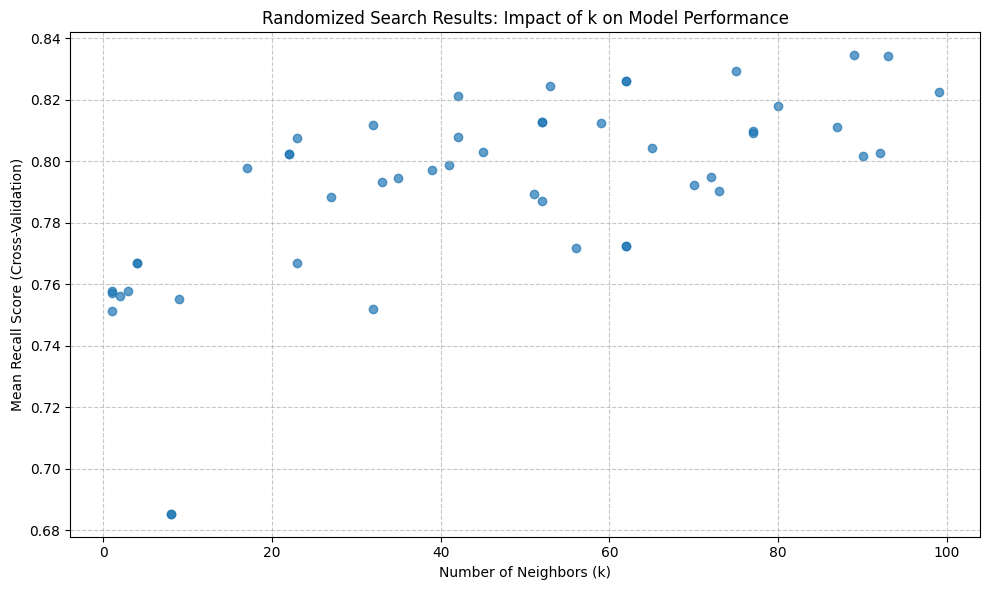

/Users/bofanchen/Desktop/data_mining/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


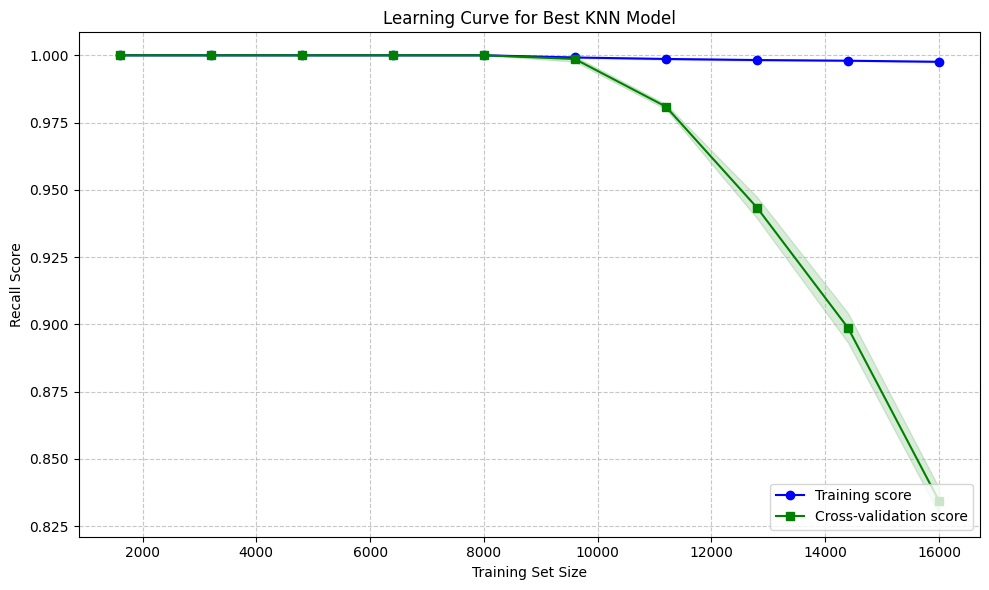

In [ ]:
# Get CV results
cv_results = random_search.cv_results_

# Extract the parameters and mean test scores
n_neighbors = [cv_results['param_n_neighbors'].data[i] for i in range(len(cv_results['params']))]
mean_test_scores = cv_results['mean_test_score']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(n_neighbors, mean_test_scores, alpha=0.7)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Recall Score (Cross-Validation)')
plt.title('Randomized Search Results: Impact of k on Model Performance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('knn_randomized_search_results.png')
plt.show()

# Plot learning curve for the best estimator
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_knn, X_train, y_train, cv=5, scoring='recall', 
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42, n_jobs=-1
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green', marker='s')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.xlabel('Training Set Size')
plt.ylabel('Recall Score')
plt.title('Learning Curve for Best KNN Model')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('knn_learning_curve.png')
plt.show()

# export to .pkl file

In [ ]:
# Save the best model using joblib
joblib.dump(best_knn, 'best_knn_model.pkl')

# Verify the model was saved successfully
print("Model saved successfully as 'best_knn_model.pkl'")

# Example of how to load the model later
# loaded_model = joblib.load('best_knn_model.pkl')
# test_predictions = loaded_model.predict(X_test)

Model saved successfully as 'best_knn_model.pkl'
